# txtファイルの読み込み及びファイル作成のテスト

In [69]:
import os
import re
import struct
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


In [70]:


# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src import OpenFile as of
from src import MSreader
from src import OpenFile
from src.GridBuilder import interpolate_grid, read_grid_from_bi


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
# 出力用フォルダの作成
path_output_folder=of.make_folder("output")
path_output_folder


Folder 'output' already exists in '.'.


'.\\output'

In [72]:

#入力データのディレクトリ
# 現在のカレントディレクトリを取得します
directory_path = os.getcwd()
path_input_folder="input"

shared_name="case60g02out"


name_input= shared_name+".ms8"
path_input_data= os.path.join(path_input_folder, name_input)

struct_name=shared_name+"S_00000"
struct_path=os.path.join(path_input_folder,struct_name)
struct_path

'input\\case60g02outS_00000'

In [73]:
# list_para_posi = [ list_tmin_posi, list_tmax_posi, list_pmin_posi, 
#                   list_pmax_posi, list_wlmax_posi, list_wgmax_posi]
#3次元で表示したいパラメータのいんっでくす指定
num_target = 4
range_istep=[0,-1]

istep stopped at: 184210


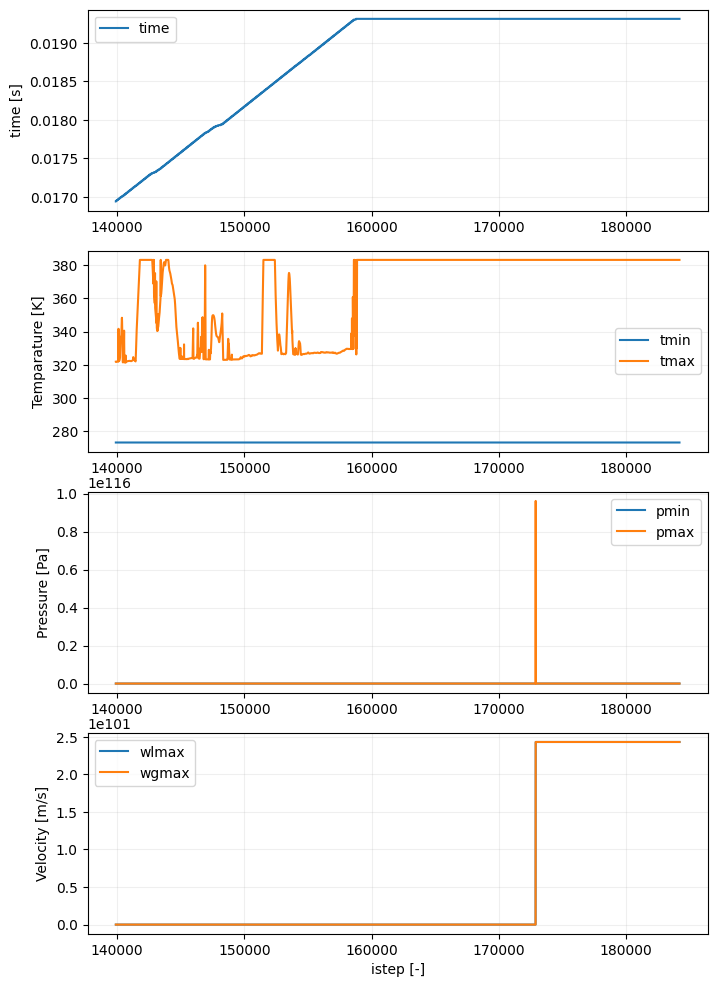

In [74]:
# 入力ファイルの読み込み
with open(path_input_data, "r") as f:
    data_txt = f.read()
#改行ごとに分割
list_preset, list_isteprow = MSreader.separate_stepblock(data_txt)

list_labels_with_posi= [ ["tmin", "tmax"], ["pmin", "pmax"], ["wlmax", "wgmax"] ]



list_labels_1d=[p for list_l in list_labels_with_posi for p in list_l ]

list_istep=[]
list_time = []
list_wlmax=[]
list_wgmax=[]
list_pmax=[]
list_pmin=[]
list_tmax=[]
list_tmin=[]

list_wlmax_posi=[]
list_wgmax_posi=[]
list_pmax_posi=[]
list_pmin_posi=[]
list_tmax_posi=[]
list_tmin_posi=[]


for p in list_isteprow:
    list_value_i=[]
    posi_i = []
    istep = MSreader.extract_values(p, "istep")
    # print(istep)

    
    for label in list_labels_1d:
        # print(label)
        values_tmp, posi_tmp= MSreader.extract_values_with_posi(p,label,True)
        # print(values_tmp,posi_i)
        list_value_i.append(values_tmp)
        posi_i.append(posi_tmp)

        # print(list_value_i[-1])

    if None in list_value_i :
        print("istep stopped at:", istep)
        break


    time_values = MSreader.extract_values(p,"time")

        
    list_istep.append(istep)
    list_time.append(time_values)
    list_tmin.append(list_value_i[0])
    list_tmax.append(list_value_i[1])
    list_pmin.append(list_value_i[2])
    list_pmax.append(list_value_i[3])
    list_wlmax.append(list_value_i[4])
    list_wgmax.append(list_value_i[5])

    list_tmin_posi.append(posi_i[0])
    list_tmax_posi.append(posi_i[1])
    list_pmin_posi.append(posi_i[2])
    list_pmax_posi.append(posi_i[3])
    list_wlmax_posi.append(posi_i[4])
    list_wgmax_posi.append(posi_i[5])


# パラメータ抽出
list_labels= [ ["time"] ,["tmin", "tmax"], ["pmin", "pmax"], ["wlmax", "wgmax"] ]
list_values= [ [list_time],[list_tmin,list_tmax], [list_pmin,list_pmax], [list_wlmax, list_wgmax]]
list_ylabel= [ "time [s]", "Temparature [K]", "Pressure [Pa]", "Velocity [m/s]" ]

list_para_posi = [ list_tmin_posi, list_tmax_posi, list_pmin_posi, list_pmax_posi, list_wlmax_posi, list_wgmax_posi]



# パラメータの数だけグラフを作成
fig, ax = plt.subplots(len(list_values),1, figsize=(8,3*len(list_values)))

for i, (values,labels) in enumerate(zip(list_values,list_labels) ):
    is_dt=0
    j=i+is_dt
    ax_i= ax[j]

    ax_i.set_ylabel(list_ylabel[j])

    for (value,label) in zip(values,labels):
        # print(label)
        ax_i.plot(list_istep[range_istep[0]:range_istep[1]],
                  value[range_istep[0]:range_istep[1]]
                  ,label=label)
        # ax_i.set_title("IstepVsParameter")
        # ax_i.set_xlabel("istep [-]")
        ax_i.grid(alpha=0.2)
        ax_i.legend()
    
    if i == len(list_values)-1 :
        ax_i.set_xlabel("istep [-]")
plt.show()

In [75]:
#座標データ抽出
points = read_grid_from_bi(path_input_folder, shared_name)

data_shape=(points[0].shape[0],points[1].shape[0],points[2].shape[0])

# 該当する座標店の表示
x,y,z = np.meshgrid(points[0],points[1],points[2], indexing='ij')


x_points=points[0][1:-1]
y_points=points[1][1:-1]
z_points=points[2][1:-1]
x_points.shape,y_points.shape,z_points.shape

((60,), (60,), (472,))

# 流路の描画

In [76]:
data_s_origin=np.array(OpenFile.get_data_from_binary(struct_path)) 
data_s = data_s_origin.reshape(data_shape, order="F")[1:-1,1:-1, 1:-1]

# 格子幅そろえる処理
delta=0.1*10**-3
X,Y,Z, data_s_ip=interpolate_grid(x_points,y_points,z_points,data_s,delta)
data_shape_after=data_s_ip.shape
data_shape_after

# 流路の等値面作成
verts, faces, normals, values = measure.marching_cubes(data_s_ip, 0.5,spacing=(delta,delta,delta))

#等値面の原点地点にoffsetを掛ける
cube_offset=np.array([[np.min(x_points),np.min(y_points),np.min(z_points)]])
width=np.max(x_points) -np.min(x_points)
width

0.00295

# 座標および流路の可視化

In [77]:

target_list = list_para_posi[num_target]
print(target_list)
array_x=np.array([x[p] for p in target_list[range_istep[0]:range_istep[1]]])
array_y=np.array([y[p] for p in target_list[range_istep[0]:range_istep[1]]])
array_z=np.array([z[p] for p in target_list[range_istep[0]:range_istep[1]]])
array_c=np.array(list_istep[range_istep[0]:range_istep[1]])
array_x,array_y,array_z

[(30, 1, 330), (30, 1, 330), (30, 1, 331), (30, 1, 332), (30, 1, 332), (30, 1, 333), (30, 1, 333), (30, 1, 333), (31, 15, 424), (31, 15, 425), (31, 15, 425), (30, 1, 335), (30, 1, 386), (30, 15, 428), (30, 15, 428), (31, 15, 428), (31, 15, 429), (31, 15, 429), (31, 15, 430), (31, 15, 430), (31, 15, 450), (31, 15, 450), (31, 15, 451), (31, 15, 424), (31, 15, 424), (31, 15, 425), (30, 15, 378), (30, 15, 378), (30, 15, 379), (30, 1, 426), (30, 1, 427), (30, 1, 427), (30, 1, 427), (30, 1, 427), (30, 1, 428), (30, 1, 428), (30, 15, 440), (30, 15, 441), (30, 15, 441), (30, 15, 441), (30, 1, 386), (30, 1, 386), (30, 1, 387), (30, 1, 388), (30, 1, 388), (30, 1, 389), (30, 1, 389), (30, 1, 390), (30, 1, 390), (30, 1, 391), (30, 1, 324), (30, 1, 392), (30, 1, 392), (30, 1, 393), (30, 1, 394), (30, 1, 394), (30, 1, 394), (30, 1, 395), (31, 15, 417), (31, 1, 465), (30, 1, 415), (30, 1, 415), (30, 1, 416), (30, 1, 416), (31, 1, 467), (31, 1, 467), (31, 1, 468), (31, 1, 468), (31, 1, 470), (29, 1, 3

(array([-0.000775, -0.000775, -0.000775, ..., -0.001525, -0.001525,
        -0.001525]),
 array([-0.000775, -0.000775, -0.000775, ..., -0.001475, -0.001475,
        -0.001475]),
 array([0.006625, 0.006625, 0.006625, ..., 0.000125, 0.000125, 0.000125]))

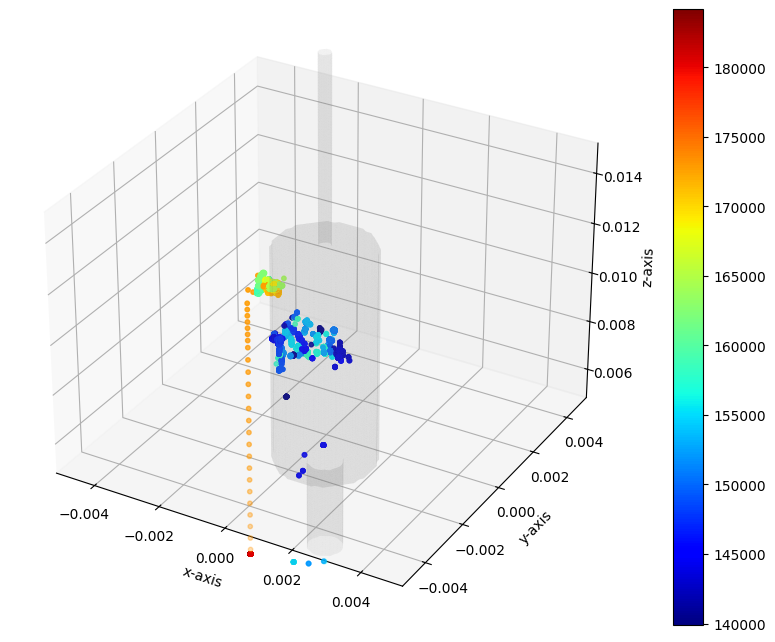

In [78]:
colormap = plt.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(array_c))

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection = '3d')


ax_scatter_obj = ax.scatter(array_x, array_y, array_z, s = 10, c = array_c, cmap = colormap)
fig.colorbar(ax_scatter_obj)



# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces]+cube_offset,alpha=0.1, facecolors='gray')
# mesh.set_edgecolor('')
# https://qiita.com/taiko1/items/23379266c1aaa2e67acc

ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() * 0.5**2

#軸スケール一定
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# 真正面から見るための視点を設定する
# ax.view_init(elev = 90, azim = 0)# elevは仰角（上下の角度）、azimは方位角（左右の角度）


plt.show()

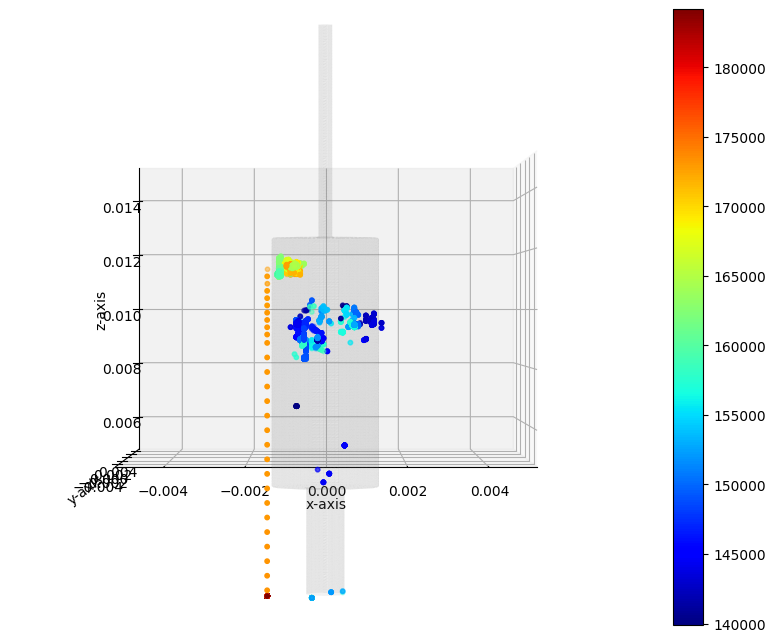

In [79]:
colormap = plt.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(array_c))

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection = '3d')


ax_scatter_obj = ax.scatter(array_x, array_y, array_z, s = 10, c = array_c, cmap = colormap)
fig.colorbar(ax_scatter_obj)



# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces]+cube_offset,alpha=0.1, facecolors='gray')
# mesh.set_edgecolor('')
# https://qiita.com/taiko1/items/23379266c1aaa2e67acc

ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() * 0.5**2

#軸スケール一定
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# 真正面から見るための視点を設定する
ax.view_init(elev = 0, azim = -90)# elevは仰角（上下の角度）、azimは方位角（左右の角度）


plt.show()